**Step 0 - install and import dependencies**

In [1]:
!pip install pythainlp
!pip install tensorflow_text
!pip install umap-learn

     |████████████████████████████████| 11.0 MB 18.3 MB/s 
     |████████████████████████████████| 743 kB 45.7 MB/s 
     |████████████████████████████████| 4.9 MB 27.4 MB/s 
     |████████████████████████████████| 86 kB 4.5 MB/s 
     |████████████████████████████████| 1.1 MB 36.7 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82709 sha256=f36e888c45700fa76c35be8a1314529233a4281ef545c2966cb68cbd06512f84
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.5-py3-none-any.whl size=52603 sha256=049e56c908993063657e1b8a55ad2563e5dbc15219f1020f9413c04aa148fa27
  Stored in directory: /root/.cache/pip/wheels/af/e9/33/04db1436df0757c42fda8ea6796d7a8586e23c85fac355f476
Successfully built umap-learn pynndescent


In [2]:
import numpy as np
import pandas as pd
import re

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
import umap

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

import pythainlp
from pythainlp.corpus.common import thai_words
from pythainlp.util import Trie
import collections


In [3]:
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3' #'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3' for a large model

model = hub.load(module_url)

In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [9]:
df = pd.read_csv("/content/drive/MyDrive/CRM/Wongnai Reviews - Small.csv")

In [10]:
df.head()

,Review ID,Review
0,1,เป็นคนที่ชอบทาน Macchiato เป็นประจำ มีวันนึงเด...
1,2,Art of Coffee Kasetsart เป็นร้านกาแฟรสชาติเยี่...
2,3,กวงทะเลเผา อาหารทะเลเค้าสดจริงๆเนื้อปูหวานไม่ค...
3,4,วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออกมาหาอะไ...
4,5,ชอบมาทานร้านนี้ถ้าอยากกินอาหารเวียดนามใกล้บ้าน...


**Step 1 - document embedding and dimension reduction**

In [11]:
#embed sentences using Universal Sentence Encoder (USE)

embed_comments_array = model(df['Review'].values).numpy()
embed_comments_array

array([[ 0.08993827,  0.01941084,  0.03787038, ..., -0.03488849,
         0.06299512,  0.04635989],
       [ 0.00634244,  0.00814594,  0.03071941, ..., -0.01478723,
        -0.03080936, -0.03316405],
       [ 0.0633687 , -0.02027139, -0.05077003, ..., -0.06530775,
        -0.00952999, -0.03439987],
       ...,
       [ 0.08775924,  0.03609736,  0.01263062, ..., -0.03102781,
        -0.03361677,  0.01928871],
       [ 0.05691195,  0.05381691, -0.0399575 , ..., -0.06598807,
        -0.05390478, -0.01037725],
       [ 0.0777048 ,  0.05080631,  0.02680681, ..., -0.0061413 ,
        -0.01313567,  0.02236264]], dtype=float32)

In [12]:
#reduce array dimensions using umap (you can chagne n_components)

reducer = umap.UMAP(random_state=42,n_components=50)
umap_embed_comments_array = reducer.fit_transform(embed_comments_array)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


**Step 2 - document clustering using KMeans**

Text(0, 0.5, 'WCSS')

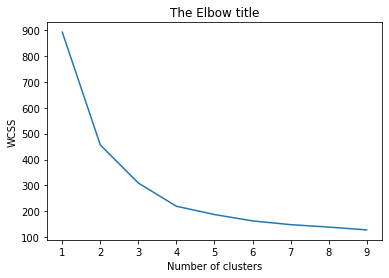

In [13]:
#run kmeans with various number of k. evaluate no. of k based on the elbow plot

wcss=[]
max_k = 10
for i in range(1, max_k):
  kmeans = KMeans(i)
  kmeans.fit(umap_embed_comments_array)
  wcss_iter = kmeans.inertia_
  wcss.append(wcss_iter)

number_clusters = range(1, max_k)
plt.plot(number_clusters,wcss)
plt.title('The Elbow title')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

In [82]:
#run kmeans with no. of clusters you see fit the most

k = 5

kmeans = KMeans(n_clusters = k)
kmeans.fit(umap_embed_comments_array)

df['KMeans ID'] = kmeans.labels_

In [83]:
#merge all reviews of each cluster into one big sentence 

df_kmeans = pd.DataFrame(columns=["KMeans ID", "texts"])


for i in range(0, k):
  row = []
  row.append(i)
  row.append(df['Review'][df['KMeans ID'] == i].to_string())
  df_kmeans.loc[len(df_kmeans)] = row

In [84]:
df_kmeans

,KMeans ID,texts
0,0,3 วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออก...
1,1,2 กวงทะเลเผา อาหารทะเลเค้าสดจริงๆเนื้อปูห...
2,2,0 เป็นคนที่ชอบทาน Macchiato เป็นประจำ มีว...
3,3,13 เคยเป็นไหมกันไหมคะ หลังอาหารมื้อใหญ่ ต่...
4,4,11 โลตัสพัฒนาการมีร้านชีทเค้กน่าหม่ำอยู่ร้...


In [85]:
#create regex compiler for removal of a character you don't want

special_characters = "/[!@#$%^&*']/g"

specialchar_pattern = re.compile(special_characters)

In [86]:
#create regex compiler for removal of any emoji

emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

In [87]:
#create regex compiler for removal of digit

number_pattern = re.compile("[0-9]")

In [88]:
#create regex compiler for removal of white space

space_pattern = re.compile("\s+")

In [89]:
#create regex compiler for removal of .

dot_pattern = re.compile(r"\.+")

In [90]:
#create regex compiler for removal of \

backslash_pattern = re.compile(r"\\+")

In [137]:
#define a function to tokenize a sentence into words - you can define words you want to remove as well as new words for tokenization

stopwords = list(pythainlp.corpus.thai_stopwords())
removed_words = ['u', 'b', 'n', 'nn', 'nn-', '\n', 'ร้าน' , 'กก' , 'บ้าน' , '[\'' , 'นะคะ' , 'ค่ะ' , 'ครับ' , 'นะครับ' , 'นะ' , 'ไหม' , 'ดิชั้น' , 'รีวิว' ,
                 'review' , 'สั่ง' , 'เกริ่น' , 'วัง' , 'สวัสดี' , 'เด' , 'ที่ตั้ง' , 'ผม' , 'ดิฉัน' , 'ฉัน' , 'ดิชั้น' , 'ตั้งอยู่' , 'น']
screening_words = stopwords + removed_words

new_words = {"สตารบัก" , 'พนักงาน' , 'บรรยากาศ' , 'เอ๊กซ์เพรสโซ่ไอซ์' , 'ลาเต้ไอซ' , 'คาราเมล' , 'มัคคิอาโต้' , 'ชาอัสสัม', 'ชาซีลอน',
             'อิตาเลียนโซดา' , 'ทะเล' , 'Macchiato' , 'อุดหนุน' , 'เบอเกอรี่' , 'ทรูคอฟฟี่' ,'สาขา.*' , 'อเมซอน' ,'ชานม' , 'ชานมไข่มุก',
             'ชาไต้หวัน' , 'ชานมไต้หวัน' , 'คาเฟอีน' , 'สไตล์' , 'จองล่วงหน้า' , 'นั่งชิล' , 'กรอบ' , '.*เค้ก' , 'มอคค่า' , 'ไม่อร่อย' 'ไม่ผ่าน',
             'ค่อนข้าง' , 'ไม่ค่อย' , 'ห้ามพลาด' , 'รถไฟฟ้า' , 'ปลาร้า' , 'เป็ด.*'}

words = new_words.union(thai_words())

custom_dictionary_trie = Trie(words)

def tokenize_to_list(sentence):
  merged = []
  words = pythainlp.word_tokenize(str(sentence), engine='newmm', custom_dict=custom_dictionary_trie)
  for word in words:
    if word not in screening_words:
      merged.append(word)
  return merged

In [138]:
#clean and tokenize sentences. count the occurences of each word

df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: emoji_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: specialchar_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: number_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: space_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: dot_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: backslash_pattern.sub(r'', x))
df_kmeans['texts_tokenized'] = df_kmeans['texts'].apply(lambda x: tokenize_to_list(x))
df_kmeans['texts_count'] = df_kmeans['texts_tokenized'].apply(lambda x: collections.Counter(x).most_common())

In [139]:
#results of tokenization

df_kmeans

,KMeans ID,texts,texts_tokenized,texts_count
0,0,วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออกมาหาอะไ...,"[มีโอกาส, ตื่น, เช้า, โอกาส, มาหา, อะ, ไช, อบ,...","[(กิน, 10), (อร่อย, 9), (ทาน, 7), (ร้านกาแฟ, 5..."
1,1,กวงทะเลเผาอาหารทะเลเค้าสดจริงๆเนื้อปูหวานไม่คส...,"[กวง, ทะเล, เผา, อาหารทะเล, เค้า, สด, เนื้อ, ป...","[(ร้านอาหาร, 11), (กิน, 7), (อร่อย, 6), (ซอย, ..."
2,2,เป็นคนที่ชอบทานMacchiatoเป็นประจำมีวันนึงเดArt...,"[คน, ชอบ, ทาน, Macchiato, เป็นประจำ, นึง, Arto...","[(ร้านกาแฟ, 13), (กาแฟ, 12), (ทาน, 7), (แวะ, 5..."
3,3,เคยเป็นไหมกันไหมคะหลังอาหารมื้อใหญ่ต่อให้อิ่เช...,"[หลังอาหาร, มื้อ, ต่อให้, อิ่, เช้า, บ่าย, เย็...","[(ชานมไข่มุก, 9), (ชา, 7), (ทาน, 6), (ไข่มุก, ..."
4,4,โลตัสพัฒนาการมีร้านชีทเค้กน่าหม่ำอยู่ร้านนึงค่...,"[โลตัส, พัฒนาการ, ชี, ท, เค้ก, หม่ำ, นึง, ค่, ...","[(ร้านกาแฟ, 10), (กาแฟ, 6), (เบเกอรี่, 4), (ทา..."


In [140]:
#show top keywords of each cluster

top_N_words = 20

for i in range(0, len(df_kmeans)):
  print(f"Cluster ID : {i}\n")
  print(f"Most common words include : {list(df_kmeans['texts_count'][i])[:top_N_words]}\n")

#tune a model by remove unwanted characters and words and add more words to a custom dictionary

Cluster ID : 0

Most common words include : [('กิน', 10), ('อร่อย', 9), ('ทาน', 7), ('ร้านกาแฟ', 5), ('กาแฟ', 5), ('อาหาร', 4), ('ชอบ', 4), ('ร้านอาหาร', 4), ('มีโอกาส', 3), ('ถนน', 3), ('คิว', 3), ('กา', 3), ('ศ', 3), ('ครั้งแรก', 3), ('ซื้อ', 3), ('เลือก', 3), ('บอ', 3), ('ลอง', 3), ('หา', 3), ('ดี', 3)]

Cluster ID : 1

Most common words include : [('ร้านอาหาร', 11), ('กิน', 7), ('อร่อย', 6), ('ซอย', 6), ('อาหาร', 6), ('ทาน', 5), ('ราคา', 5), ('เพื่อน', 4), ('ส้มตำ', 4), ('ไทย', 4), ('แซ่บ', 4), ('รสชาติ', 4), ('ไร้', 3), ('าน', 3), ('ส', 3), ('ยำ', 3), ('รา', 3), ('เก่าแก่', 3), ('รอบ', 3), ('เป็ด', 3)]

Cluster ID : 2

Most common words include : [('ร้านกาแฟ', 13), ('กาแฟ', 12), ('ทาน', 7), ('แวะ', 5), ('ชอบ', 4), ('นั่ง', 4), ('ดี', 4), ('คน', 3), ('นึง', 3), (':', 3), ('กร้าน', 3), ('รอ', 3), ('พัก', 3), ('เจอ', 3), ('อย', 3), ('อเมซอน', 3), ('แถว', 3), ('น่ารัก', 3), ('กิน', 3), ('รสชาติ', 2)]

Cluster ID : 3

Most common words include : [('ชานมไข่มุก', 9), ('ชา', 7), ('ทาน', 6

**Step 4 - result discussion**

*   Cluster ID : 0 - ร้านที่มีโอกาสจะมาทาน ร้านอร่อย

*   Cluster ID : 1 - ร้านส้มตำ กินกับเพื่อน รสแซ่บ เจ้าเก่า

*   Cluster ID : 2 - ร้านกาแฟ รสชาติดี นั่งชิล

*   Cluster ID : 3 - ร้านสารพัดชา ชานม ไข่มุก ชาเขียว

*   Cluster ID : 4 - ร้านกาแฟ ที่ขายเบเกอรี่ พาย เค้ก

